In [1]:
from graphs.my_graph import graphs # my custom dataviz environment
mg = graphs('notebook') # initialize a visualization env optimize for notebook display
import numpy as np
import pydicom, sys
import pandas as pd

In [36]:
folder_entries = ['0a0a153e5','0a0aaeade', '0a0afe712', '0a0a4ff97',
     '0a0aaf9f1', '0a0a9133e','0a0abef61', '0a0a9691a','0a0ad4532',
     '0a0a9a8ef','0a0ae315e']

In [15]:
# load training data
df= pd.read_csv('data/stage_1_train.csv')

In [14]:
data = {}
for Id, label in zip(df['ID'], df['Label']):
    id_key, area_key = Id.split('_')[1:]
    if id_key not in data:
        data[id_key] = {area_key:np.float(label)}
    else:
        data[id_key][area_key] = np.float(label)    

In [30]:
filename = 'data/ID_0a0ad4532.dcm'

In [37]:
for fe in folder_entries:
    print(data[fe])

{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 0.0, 'subdural': 0.0, 'any': 0.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 0.0, 'subdural': 0.0, 'any': 0.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 0.0, 'subdural': 1.0, 'any': 1.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 0.0, 'subdural': 0.0, 'any': 0.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 0.0, 'subdural': 1.0, 'any': 1.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 1.0, 'subdural': 0.0, 'any': 1.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 0.0, 'subdural': 0.0, 'any': 0.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventricular': 0.0, 'subarachnoid': 0.0, 'subdural': 0.0, 'any': 0.0}
{'epidural': 0.0, 'intraparenchymal': 0.0, 'intraventric

In [39]:
ds = pydicom.dcmread('data/ID_%s.dcm' % folder_entries[2])
print(ds)

(0008, 0018) SOP Instance UID                    UI: ID_0a0afe712
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_1d580c01'
(0020, 000d) Study Instance UID                  UI: ID_c33e8e0e6d
(0020, 000e) Series Instance UID                 UI: ID_4488bf15c2
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-118', '1.35887748', '319.788684']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.987688341', '-0.156434465']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.50390625', '0.50390625']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         U

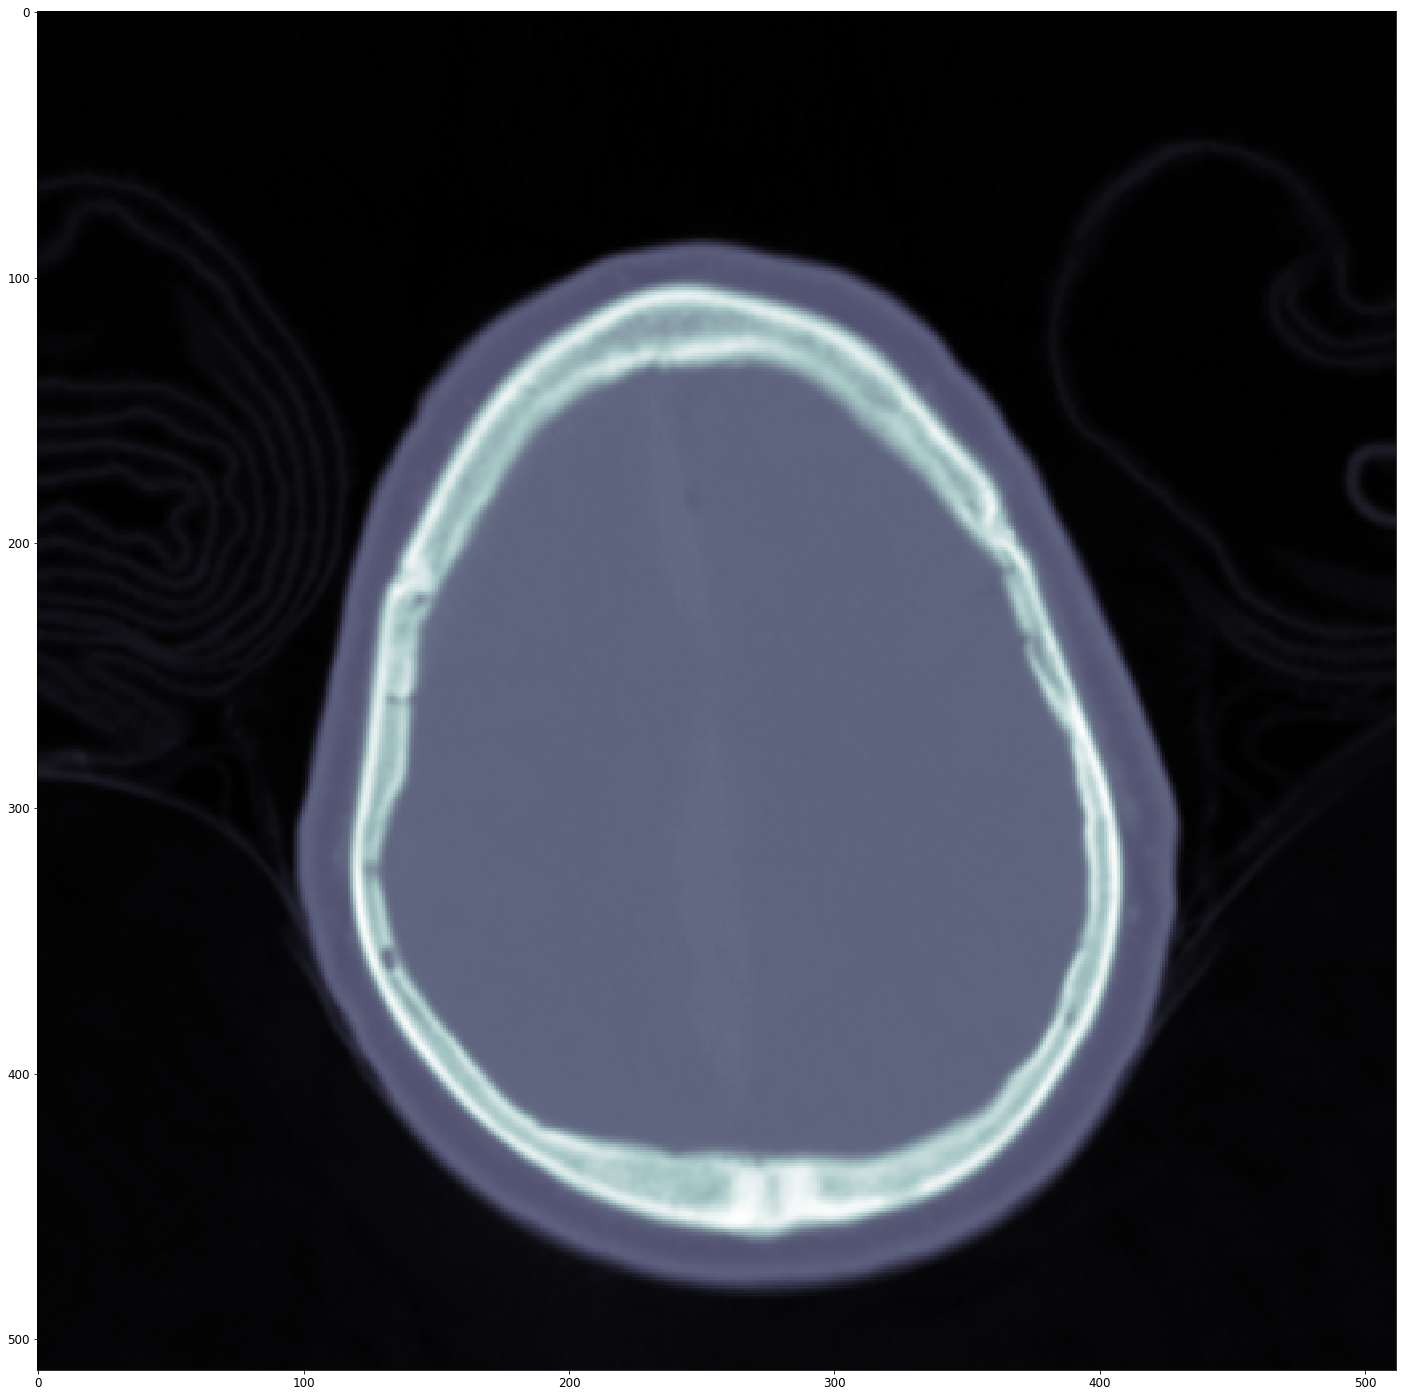

In [40]:
import matplotlib.pylab as plt
plt.figure(figsize=(25,25))
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

In [25]:
ds.pixel_array[0]

array([-2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000, -2000,
       -2000, -2000,